In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
!pip install nilearn

     |████████████████████████████████| 2.5MB 2.6MB/s 


In [5]:
#!wget https://www.cbica.upenn.edu/sbia/Spyridon.Bakas/MICCAI_BraTS/2018/MICCAI_BraTS_2018_Data_Training.zip

In [6]:
import os
os.listdir('/content/drive/My Drive/MICCAI_BraTS/2018')

['MICCAI_BraTS_2018_Data_Training.zip',
 'MICCAI_BraTS_2018_Data_Validation.zip',
 'train',
 'unet_complete',
 'unet_all']

In [7]:
import nibabel as nib
import nilearn as nil
from nilearn.plotting import view_img, glass_brain, plot_anat, plot_epi
import matplotlib.pyplot as plt
import numpy as np
import cv2
import shutil
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras import backend as K

Using TensorFlow backend.


In [8]:
members = os.listdir('/content/drive/My Drive/MICCAI_BraTS/2018/train/hgg/3D/mask')
members = ['/content/drive/My Drive/MICCAI_BraTS/2018/train/hgg/3D/mask/'+name for name in members]
list_members = tf.data.Dataset.from_tensor_slices(members)

In [9]:
def process_path(file_path):
    sep = '/'
    name_mask = file_path.numpy().decode('utf-8')
    parts = name_mask.split('/')
    parts[-2] = 'flair'
    name_flair = sep.join(parts)
    parts[-2] = 't1'
    name_t1 = sep.join(parts)
    parts[-2] = 't1ce'
    name_t1ce = sep.join(parts)
    parts[-2] = 't2'
    name_t2 = sep.join(parts)

    buffer = np.full((240,240,5), 255)

    flair = nib.load(name_flair)
    flair = flair.get_fdata()
    flair = np.concatenate((flair,buffer), axis=-1)

    t1 = nib.load(name_t1)
    t1 = t1.get_fdata()
    t1 = np.concatenate((t1,buffer), axis=-1)

    t1ce = nib.load(name_t1ce)
    t1ce = t1ce.get_fdata()
    t1ce = np.concatenate((t1ce,buffer), axis=-1)

    t2 = nib.load(name_t2)
    t2 = t2.get_fdata()
    t2 = np.concatenate((t2,buffer), axis=-1)

    img = np.stack((flair, t1, t1ce, t2), axis=-1)

    mask = nib.load(name_mask)
    mask = mask.get_fdata()
    mask = np.concatenate((mask,buffer), axis=-1)
     
    img = tf.convert_to_tensor(img, np.float16)
    mask = tf.convert_to_tensor(mask, np.float16)

    return img, mask

In [10]:
def load_image_wrapper(files):
    a, b = tf.py_function(process_path, [files], [tf.float16, tf.float16])
    return a, b

In [11]:
def process_image(img, label):
    img = img/255
    img = tf.cast(img, tf.float64)
    bg =  tf.cast(tf.equal(label, 0), tf.float64)
    lab1 = tf.cast(tf.equal(label, 1), tf.float64)
    lab2 = tf.cast(tf.equal(label, 2), tf.float64)
    lab4 = tf.cast(tf.equal(label, 4), tf.float64)
    mask = tf.stack([bg, lab1, lab2, lab4], axis=-1)
    return img , mask

In [12]:
AUTO = tf.data.experimental.AUTOTUNE

In [13]:
train_data = list_members.map(load_image_wrapper)
train_data = train_data.map(process_image).cache().batch(1).prefetch(buffer_size=AUTO)

In [14]:
image1, image2 = next(iter(train_data))

In [15]:
image1.shape, image2.shape

(TensorShape([1, 240, 240, 160, 4]), TensorShape([1, 240, 240, 160, 4]))

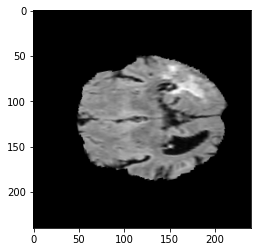

In [14]:
plt.imshow(image1[1,:,:,70,0], cmap='gray')

In [16]:
def down_conv_vnet(input_mat, n_layers, reps):
    
    ip = input_mat

    for i in range(reps):
        c1 = Conv3D(n_layers, kernel_size=(5,5,5), strides=(1,1,1), padding='same')(ip)
        ip = PReLU()(c1)

    add1 = add([input_mat, ip])

    return ip   

In [17]:
def VNet():
    inputs = Input((240,240,160,4))

    c1 = Conv3D(16, kernel_size=(5,5,5), strides=(1,1,1), padding='same')(inputs)              # 128x128x64x16
    c1 = PReLU()(c1)                                                                                                           # 128x128x64x16

    repeat1 = concatenate(4 * [inputs], axis=-1)                                                               # 128x128x64x16
    add1 = add([c1, repeat1])                                                                                       # 128x128x64x16

    down1 = Conv3D(32, kernel_size=(2,2,2), strides=(2,2,2))(add1)                                  # 64x64x32x32
    layer1 = PReLU()(down1)                                                                                               # 64x64x32x32

    add2 = down_conv_vnet(layer1, 32, 2)                                                                              # 64x64x32x32
    #add2 = add([layer1, c2])                                                                                                # 64x64x32x32
    down2 = Conv3D(64, kernel_size=(2,2,2), strides=(2,2,2))(add2)                                 # 32x32x16x64
    layer2 = PReLU()(down2)                                                                                              # 32x32x16x64

    add3 = down_conv_vnet(layer2, 64, 3)                                                                            # 32x32x16x64
    #add3 = add([layer2, c3])                                                                                              # 32x32x16x64
    down3 = Conv3D(128, kernel_size=(2,2,2), strides=(2,2,2))(add3)                               # 16x16x8x128
    layer3 = PReLU()(down3)                                                                                              # 16x16x8x128

    add4 = down_conv_vnet(layer3, 128, 3)                                                                           # 16x16x8x128
    #add4 = add([layer3, c4])                                                                                              # 16x16x8x128
    down4 = Conv3D(256, kernel_size=(2,2,2), strides=(2,2,2))(add4)                               # 8x8x4x256
    layer4 = PReLU()(down4)                                                                                              # 8x8x4x256

    add5 = down_conv_vnet(layer4, 256, 3)                                                                          # 8x8x4x256
    #add5 = add([layer4, c5])                                                                                              # 8x8x4x256
    up1 = Conv3DTranspose(128, kernel_size=(2,2,2), strides=(2,2,2))(add5)                    # 16x16x8x128
    layer5 = PReLU()(up1)                                                                                                  # 16x16x8x128

    add6 = down_conv_vnet(concatenate([layer5, add4]), 256, 3)                                                      # 16x16x8x256
    #add6 = add([layer5, c6])                                                                                              # 16x16x8x256
    up2 = Conv3DTranspose(64, kernel_size=(2,2,2), strides=(2,2,2))(add6)                     # 32x32x16x64
    layer6 = PReLU()(up2)                                                                                                  # 32x32x16x64

    add7 = down_conv_vnet(concatenate([layer6, add3]), 128, 3)                                                       # 32x32x16x128
    #add7 = add([layer6, c7])                                                                                               # 32x32x16x128
    up3 = Conv3DTranspose(32, kernel_size=(2,2,2), strides=(2,2,2))(add7)                     # 64x64x32x32
    layer7 = PReLU()(up3)                                                                                                  # 64x64x32x32
    
    add8 = down_conv_vnet(concatenate([layer7, add2]), 64, 2)                                                         # 64x64x32x64
    #add8 = add([layer7, c8])                                                                                               # 64x64x32x64
    up4 = Conv3DTranspose(16, kernel_size=(2,2,2), strides=(2,2,2))(add8)                      # 128x128x64x16
    layer8 = PReLU()(up4)                                                                                                  # 128x128x64x16

    add9 = down_conv_vnet(concatenate([layer8, add1]), 32, 1)                                                         # 128x128x64x32
    #add9 = add([layer8, c9])                                                                                              # 128x128x64x32

    c2 = Conv3D(4, kernel_size=(1,1,1), strides=(1,1,1))(add9)                                          # 128x128x64x2
    out = Softmax()(c2)                                                                                                     # 128x128x64x2

    model = Model(inputs=inputs, outputs=out)
    return model

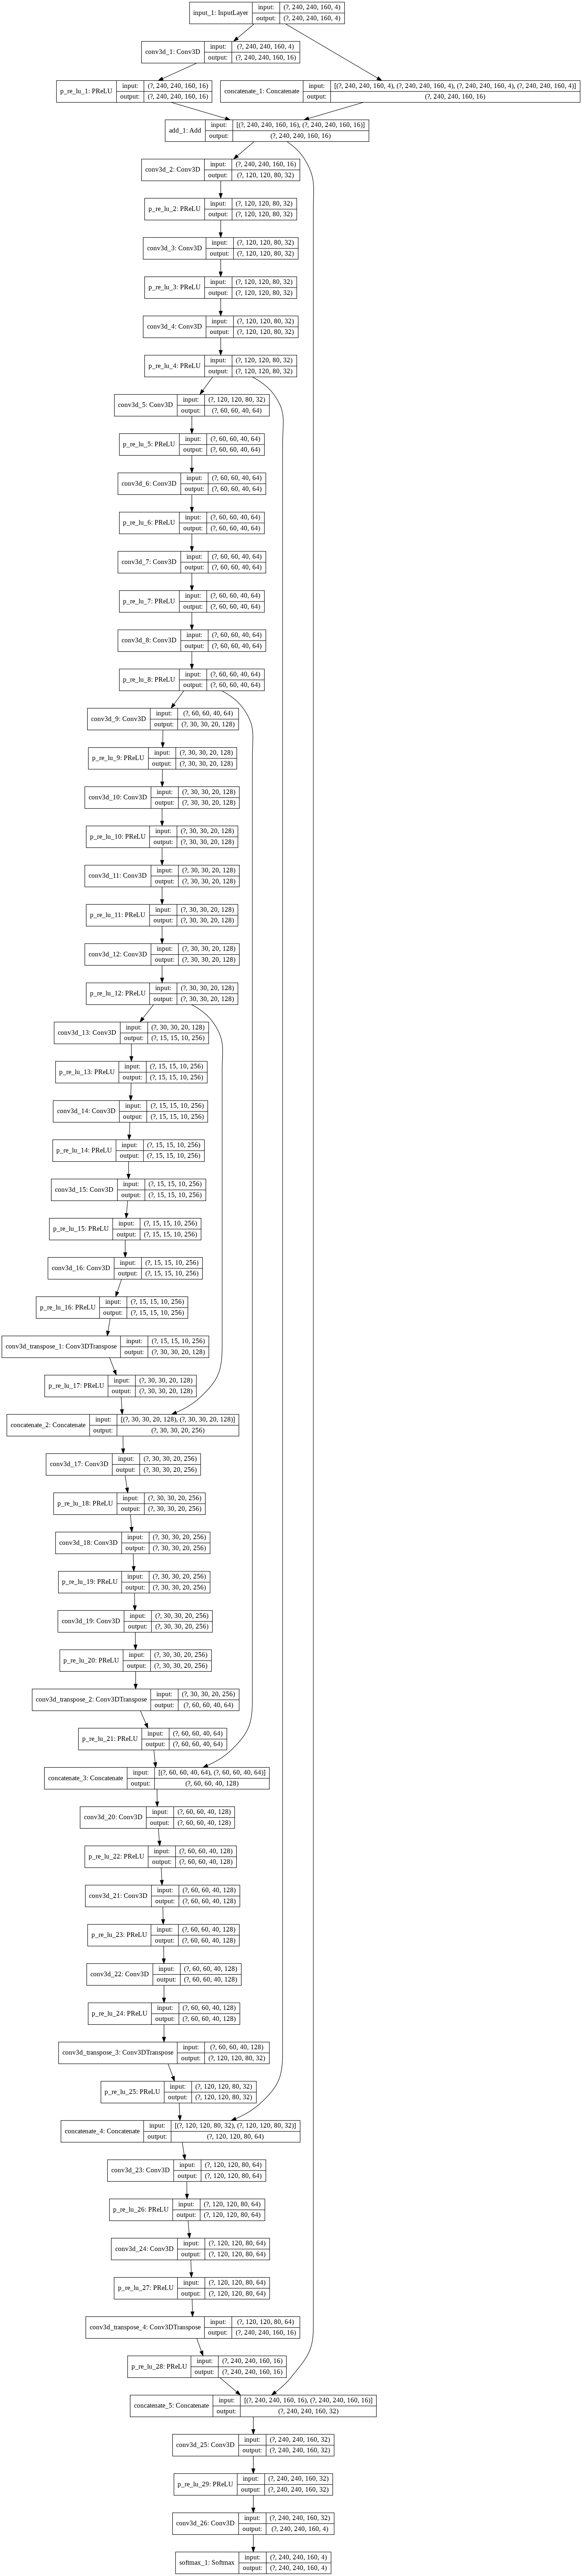

In [18]:
vnet = VNet()
tf.keras.utils.plot_model(vnet, show_shapes=True)

In [19]:
def dice_coef(y_true, y_pred, smooth=1.0):
    ''' Dice Coefficient
    Args:
        y_true (np.array): Ground Truth Heatmap (Label)
        y_pred (np.array): Prediction Heatmap
    '''

    class_num = 4
    for i in range(class_num):
        y_true_f = K.flatten(y_true[:,:,:,:,i])
        y_pred_f = K.flatten(y_pred[:,:,:,:,i])
        intersection = K.sum(y_true_f * y_pred_f)
        loss = ((2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth))
        if i == 0:
            total_loss = loss
        else:
            total_loss = total_loss + loss
    total_loss = total_loss / class_num
    return total_loss

In [20]:
def dice_coef_loss(y_true, y_pred):
    ''' Dice Coefficient Loss
    Args:
        y_true (np.array): Ground Truth Heatmap (Label)
        y_pred (np.array): Prediction Heatmap
    '''
    return 1-dice_coef(y_true, y_pred)

In [21]:
vnet.compile(optimizer=Adam(lr=1e-4), loss=dice_coef_loss, metrics=[dice_coef])

In [22]:
vnet.train_on_batch(image1, image2)

ResourceExhaustedError: ignored

In [19]:
EPOCHS = 5

In [ ]:
loss_tracker = []
for ep in range(EPOCHS):
    loss = 0
    steps = 0
    print(ep+1, '/', EPOCHS)
    for (abc, efg) in train_data:
        
        history = vnet.train_on_batch(abc, efg)
        loss += history[0]
        steps += 1
        print('Step : ', steps, ', Loss : ', history[0], ', Dice Coeff : ', history[1])

        #printm()
    loss_tracker.append(loss/steps)

1 / 5
